🧠 OptiRoute - Forecasting for Efficient Taxi Allocation</br>
This notebook implements the OptiRoute system, an AI-driven approach to optimize taxi driver allocation based on historical ride data.

In [1]:
import logging
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from pandas.errors import SettingWithCopyWarning

# Suppress info/debug logs globally
logging.getLogger().setLevel(logging.WARNING)
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Suppress specific warnings you might see
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', SettingWithCopyWarning)

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('Taxi_data.csv')

In [3]:
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
print(null_columns)

trip_distance    50
trip_duration    50
fare_amount      50
dtype: int64


**Data Preprocessing and Imputation</br>**

Objective: Clean the dataset and prepare it for modeling.

Steps Performed:

*   Converted pickup_datetime to proper datetime format.
*   Extracted time-based features like date and day_of_week.
*   Removed unrealistic trips (under 1 min or over 2 hrs).
*   Imputed missing values (trip_distance, trip_duration, fare_amount) using median imputation.


In [4]:
# Load and convert datetime
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')

# Extract time features
df['hour'] = df['pickup_datetime'].dt.hour
df['day_of_week'] = df['pickup_datetime'].dt.day_name()
df['date'] = df['pickup_datetime'].dt.date

df = df[(df['trip_duration'] > 1) & (df['trip_duration'] <= 120)]

# Impute missing numeric values with median
for col in ['trip_distance', 'trip_duration', 'fare_amount']:
    df[col] = df[col].fillna(df[col].median())

**Clustering and Zone Assignment**

Objective: Group locations into logical demand-based service zones.

Steps Performed:

*   Simulated or encoded pickup_area using label encoding or coordinate approximation.
*   Applied K-Means clustering to assign a zone_id to each ride.
*   Result: Each trip is mapped to a zone to enable demand forecasting per zone.

In [5]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the pickup_area
ohe = OneHotEncoder(sparse_output=False)
pickup_encoded = ohe.fit_transform(df[['pickup_area']])

# Apply KMeans clustering
kmeans = KMeans(n_clusters=8, random_state=42)
df['zone_id'] = kmeans.fit_predict(pickup_encoded)

In [6]:
df

,trip_id,pickup_datetime,pickup_day,pickup_area,dropoff_area,trip_distance,trip_duration,fare_amount,driver_id,hour,day_of_week,date,zone_id
0,1,2025-08-05 06:36:00,Thursday,Mirdif,Karama,17.47,46.3,38.27,118,6,Tuesday,2025-08-05,5
1,2,2025-02-05 06:24:00,Friday,Downtown,Marina,20.32,44.1,61.99,84,6,Wednesday,2025-02-05,2
2,3,2025-01-05 06:49:00,Thursday,Business Bay,Al Barsha,7.76,22.3,26.77,167,6,Sunday,2025-01-05,1
3,4,2025-09-05 10:29:00,Friday,Mirdif,Downtown,16.37,42.8,47.02,195,10,Friday,2025-09-05,5
4,5,2025-04-05 03:06:00,Sunday,JLT,Business Bay,15.15,32.7,49.39,133,3,Saturday,2025-04-05,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2996,2025-01-05 10:59:00,Thursday,Deira,Downtown,17.74,44.6,35.64,147,10,Sunday,2025-01-05,3
2996,2997,2025-01-05 12:22:00,Thursday,JLT,Mirdif,13.57,29.4,50.85,168,12,Sunday,2025-01-05,6
2997,2998,2025-01-05 10:37:00,Thursday,Business Bay,Marina,19.60,58.4,51.25,2,10,Sunday,2025-01-05,1
2998,2999,2025-02-05 13:25:00,Friday,Marina,Karama,13.16,27.7,51.02,65,13,Wednesday,2025-02-05,0


**Forecasting**

Objective: Predict future ride demand per zone using time series forecasting.

Models Used:

*   Prophet: Captures hourly and weekly seasonality, and automatically detects trend changepoints using a piecewise linear growth model.
*   ARIMA: Best suited for stationary, linear series.
*   Decision Tree Regressor: Baseline model using lag and time features.

Steps Performed:

*   Aggregated ride counts by zone and day.
*   Split data into training (70%) and testing (30%).
*   Evaluated all three models using RMSE, MAE, and MAPE.
*   Selected the best model per zone based on RMSE.

In [7]:
!pip install pandas numpy scikit-learn matplotlib prophet statsmodels

In [8]:
import pandas as pd
import numpy as np
import random
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Seeds for full reproducibility
np.random.seed(42)
random.seed(42)

# --- Load & Preprocess ---
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['date'] = df['pickup_datetime'].dt.date
daily_counts = df.groupby(['date', 'zone_id']).size().reset_index(name='rides')

# --- Evaluation Metric ---
def eval_metrics(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    min_len = min(len(true), len(pred))
    true = true[:min_len]
    pred = pred[:min_len]
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    mape = np.mean(np.abs((true - pred) / (true + 1e-5))) * 100
    return round(rmse, 2), round(mae, 2), round(mape, 2)

# --- Forecast Loop ---
forecast_results = {}
zones = daily_counts['zone_id'].unique()

for zone in zones:
    zone_df = daily_counts[daily_counts['zone_id'] == zone].copy()
    zone_df['ds'] = pd.to_datetime(zone_df['date'])
    zone_df['y'] = zone_df['rides']
    zone_df = zone_df[['ds', 'y']]

    train_size = int(len(zone_df) * 0.7)
    train = zone_df.iloc[:train_size]
    test = zone_df.iloc[train_size:]

    # --- Prophet ---
    prophet_model = Prophet(daily_seasonality=True)
    prophet_model.fit(train)
    future = prophet_model.make_future_dataframe(periods=5)
    forecast = prophet_model.predict(future)
    prophet_pred = forecast.iloc[-5:]['yhat'].values

    # --- ARIMA ---
    adf_result = adfuller(train['y'])
    if adf_result[1] < 0.05:
        arima_model = ARIMA(train['y'], order=(5, 1, 0)).fit()
        arima_pred = arima_model.forecast(steps=5)
    else:
        arima_pred = np.full(5, train['y'].mean())

    # --- Decision Tree ---
    zone_baseline = zone_df.copy()
    zone_baseline['day'] = zone_baseline['ds'].dt.dayofweek
    zone_baseline['lag1'] = zone_baseline['y'].shift(1)
    zone_baseline.dropna(inplace=True)
    X = zone_baseline[['day', 'lag1']]
    y = zone_baseline['y']

    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X, y)

    last_day = zone_baseline['day'].iloc[-1]
    last_lag = zone_baseline['lag1'].iloc[-1]

    dt_pred = []
    prev_pred = last_lag
    for i in range(1, 6):
        current_day = (last_day + i) % 7
        X_input = pd.DataFrame({'day': [current_day], 'lag1': [prev_pred]})
        pred = dt_model.predict(X_input)[0]
        dt_pred.append(pred)
        prev_pred = pred
    dt_pred = np.array(dt_pred)

    # --- Evaluation ---
    eval_len = min(len(test), 5)
    eval_true = test['y'].values[:eval_len] if len(test) >= eval_len else train['y'].values[-eval_len:]

    forecast_results[zone] = {
        'Prophet': prophet_pred,
        'ARIMA': arima_pred,
        'DecisionTree': dt_pred,
        'metrics': {
            'Prophet': eval_metrics(eval_true, prophet_pred),
            'ARIMA': eval_metrics(eval_true, arima_pred),
            'DecisionTree': eval_metrics(eval_true, dt_pred)
        }
    }

for zone, models in forecast_results.items():
    print(f"\nZone {zone} Forecasting Results:")
    for model_name, scores in models['metrics'].items():
        print(f"  {model_name} => RMSE: {scores[0]}, MAE: {scores[1]}, MAPE: {scores[2]}%")
    best_model = min(models['metrics'], key=lambda k: models['metrics'][k][0])  # min RMSE
    print(f"  ➤ Best model: {best_model}")

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 4.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpka_xx16q/n7e5r2s8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpka_xx16q/xv9936qs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57089', 'data', 'file=/tmp/tmpka_xx16q/n7e5r2s8.json', 'init=/tmp/tmpka_xx16q/xv9936qs.json', 'output', 'file=/tmp/tmpka_xx16q/prophet_modelypdjle5b/prophet_model-20250616175222.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
17:52:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:52:23 - cmdstanpy - INFO - Chain [1] done processing
INFO


Zone 0 Forecasting Results:
  Prophet => RMSE: 13.13, MAE: 12.14, MAPE: 42.18%
  ARIMA => RMSE: 10.12, MAE: 8.81, MAPE: 31.28%
  DecisionTree => RMSE: 7.85, MAE: 7.0, MAPE: 24.22%
  ➤ Best model: DecisionTree

Zone 1 Forecasting Results:
  Prophet => RMSE: 6.73, MAE: 6.12, MAPE: 13.83%
  ARIMA => RMSE: 12.7, MAE: 12.5, MAPE: 29.55%
  DecisionTree => RMSE: 8.27, MAE: 7.67, MAPE: 17.61%
  ➤ Best model: Prophet

Zone 2 Forecasting Results:
  Prophet => RMSE: 10.2, MAE: 8.08, MAPE: 29.16%
  ARIMA => RMSE: 7.54, MAE: 5.86, MAPE: 21.23%
  DecisionTree => RMSE: 6.27, MAE: 5.33, MAPE: 18.69%
  ➤ Best model: DecisionTree

Zone 3 Forecasting Results:
  Prophet => RMSE: 4.01, MAE: 3.31, MAPE: 8.94%
  ARIMA => RMSE: 2.48, MAE: 2.48, MAPE: 6.42%
  DecisionTree => RMSE: 2.89, MAE: 1.67, MAPE: 3.97%
  ➤ Best model: ARIMA

Zone 4 Forecasting Results:
  Prophet => RMSE: 2.54, MAE: 2.11, MAPE: 5.82%
  ARIMA => RMSE: 7.88, MAE: 6.8, MAPE: 17.72%
  DecisionTree => RMSE: 3.11, MAE: 3.0, MAPE: 8.18%
  ➤ Be

**Allocation & Evaluation**

Objective: Allocate drivers to zones based on forecasted demand and evaluate the efficiency.

Steps Performed:

Allocated drivers proportionally to forecasted demand.

Simulated key metrics:

*   Match Rate: % of demand that could be met.
*   Idle Time: Estimated unmet ride requests.
*   Fuel Wastage: Distance travelled without passengers.
*   Additiomally added a driver buffer to simulate oversupply.



**Short Term Prediction**

In [9]:
from tabulate import tabulate

total_available_drivers = 155
ALLOCATION_TOLERANCE = 0.9  # assumed constant for logic

print(f"\n📆 Driver Allocation for Next 12 Hours (Based on Daily Forecasts)\n")

predicted_demand = {}
zone_buffers = {}

# Step 1: Predict demand and compute per-zone buffers
for zone, models in forecast_results.items():
    best_model = min(models['metrics'], key=lambda k: models['metrics'][k][0])  # model with lowest RMSE
    daily_forecast = models[best_model][0]
    demand_12hr = max(0, daily_forecast * 0.5)
    predicted_demand[zone] = demand_12hr

    mape = models['metrics'][best_model][2] / 100
    buffer = min(1 + mape, 1.6)
    zone_buffers[zone] = buffer

# Step 2: Driver allocation using per-zone buffers (initial allocation)
driver_allocation = {}
for zone, demand in predicted_demand.items():
    buffer = zone_buffers.get(zone, 1.0)
    driver_allocation[zone] = demand * buffer

# Step 3: Scale allocations to not exceed total available drivers
total_buffered_demand = sum(driver_allocation.values())

if total_buffered_demand > total_available_drivers:
    scale_factor = total_available_drivers / total_buffered_demand
    for zone in driver_allocation:
        driver_allocation[zone] = round(driver_allocation[zone] * scale_factor)
else:
    for zone in driver_allocation:
        driver_allocation[zone] = round(driver_allocation[zone])

# Step 4: Detect over- and under-allocated zones
over_zones = []
under_zones = []

for zone in driver_allocation:
    demand = predicted_demand[zone]
    allocated = driver_allocation[zone]
    surplus = allocated - demand
    shortfall = demand - allocated

    if shortfall > ALLOCATION_TOLERANCE:
        under_zones.append((zone, int(round(shortfall))))
    elif surplus > ALLOCATION_TOLERANCE:
        over_zones.append((zone, int(round(surplus))))

# Step 5: Reallocation
suggestions = []
for under_zone, need in under_zones:
    for i in range(len(over_zones)):
        over_zone, surplus = over_zones[i]
        if surplus > 0 and need > 0:
            move = min(surplus, need)
            driver_allocation[under_zone] += move
            driver_allocation[over_zone] -= move
            suggestions.append(f"➡️ Moved {move} driver(s) from Zone {over_zone} to Zone {under_zone}")
            over_zones[i] = (over_zone, surplus - move)
            need -= move
        if need == 0:
            break

# Print reallocation actions BEFORE table
print("\n🔁 Reallocation Actions Applied:")
if suggestions:
    for s in suggestions:
        print(s)
else:
    print("✅ No reallocation needed. Driver allocation was already optimal.")

# Step 6: Evaluation after reallocation
table_data = []
total_fuel_waste_km = 0

for zone in driver_allocation:
    demand = predicted_demand[zone]
    drivers = driver_allocation[zone]
    surplus = drivers - demand
    shortfall = demand - drivers

    match_rate = min(100, round((drivers / (demand + 1e-5)) * 100, 2))
    unmet = round(shortfall, 2) if shortfall > ALLOCATION_TOLERANCE else 0

    if surplus > ALLOCATION_TOLERANCE:
        fuel_waste_km = int(surplus * (1 + surplus / (demand + 1e-5)) * 5)
    else:
        fuel_waste_km = 0

    total_fuel_waste_km += fuel_waste_km

    if shortfall > ALLOCATION_TOLERANCE:
        action = f"📢 Still need {round(shortfall)}"
    elif surplus > ALLOCATION_TOLERANCE:
        action = f"📉 Still over by {round(surplus)}"
    else:
        action = "✅ Balanced"

    table_data.append([
        zone,
        round(demand, 2),
        drivers,
        f"{match_rate}%",
        unmet,
        fuel_waste_km,
        action
    ])

# Step 7: Print final allocation table
headers = ["Zone", "Forecasted Demand (12 hrs)", "Allocated Drivers", "Match Rate", "Unmet Demand", "Fuel Waste (km)", "Action"]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))
print(f"\n🛢️ Total Estimated Fuel Wastage: {total_fuel_waste_km} km for Next 12 Hours")


📆 Driver Allocation for Next 12 Hours (Based on Daily Forecasts)


🔁 Reallocation Actions Applied:
➡️ Moved 2 driver(s) from Zone 0 to Zone 3
➡️ Moved 1 driver(s) from Zone 2 to Zone 4
╒════════╤══════════════════════════════╤═════════════════════╤══════════════╤════════════════╤═══════════════════╤═════════════════╕
│   Zone │   Forecasted Demand (12 hrs) │   Allocated Drivers │ Match Rate   │   Unmet Demand │   Fuel Waste (km) │ Action          │
╞════════╪══════════════════════════════╪═════════════════════╪══════════════╪════════════════╪═══════════════════╪═════════════════╡
│      0 │                        21.5  │                  21 │ 97.67%       │            0   │                 0 │ ✅ Balanced     │
├────────┼──────────────────────────────┼─────────────────────┼──────────────┼────────────────┼───────────────────┼─────────────────┤
│      1 │                        18.44 │                  18 │ 97.63%       │            0   │                 0 │ ✅ Balanced     │
├────────┼──

Long Term prediction

In [10]:
from tabulate import tabulate

total_available_drivers = 295
ALLOCATION_TOLERANCE = 0.9  # Threshold for over/under allocation
MAX_BUFFER = 1.6  # Cap on buffer value

print("\n📆 Weekly Driver Allocation\n")

# Loop through 5 forecast days
for forecast_day_index in range(5):
    print(f"\n📅 Day {forecast_day_index + 1} (Forecast Index {forecast_day_index}):")

    predicted_demand = {}
    zone_buffers = {}

    # Step 1: Predict demand and compute per-zone buffers for this forecast day
    for zone, models in forecast_results.items():
        best_model = min(models['metrics'], key=lambda k: models['metrics'][k][0])  # model with lowest RMSE
        daily_forecast = models[best_model][forecast_day_index]
        demand = max(0, daily_forecast)  # full daily forecast demand

        predicted_demand[zone] = demand

        # Calculate buffer based on MAPE metric (index 2)
        mape = models['metrics'][best_model][2] / 100  # convert % to ratio
        buffer = 1 + mape
        buffer = min(buffer, MAX_BUFFER)
        zone_buffers[zone] = buffer

    # Step 2: Initial driver allocation with per-zone buffers
    driver_allocation = {}
    for zone, demand in predicted_demand.items():
        buffered_demand = demand * zone_buffers.get(zone, 1.0)
        driver_allocation[zone] = buffered_demand

    # Step 3: Scale allocations to fit total available drivers
    total_buffered_demand = sum(driver_allocation.values())
    if total_buffered_demand > total_available_drivers:
        scale_factor = total_available_drivers / total_buffered_demand
        for zone in driver_allocation:
            driver_allocation[zone] = round(driver_allocation[zone] * scale_factor)
    else:
        for zone in driver_allocation:
            driver_allocation[zone] = round(driver_allocation[zone])

    # Step 4: Detect over- and under-allocated zones
    over_zones = []
    under_zones = []

    for zone in driver_allocation:
        demand = predicted_demand[zone]
        allocated = driver_allocation[zone]
        surplus = allocated - demand
        shortfall = demand - allocated

        if shortfall > ALLOCATION_TOLERANCE:
            under_zones.append((zone, int(round(shortfall))))
        elif surplus > ALLOCATION_TOLERANCE:
            over_zones.append((zone, int(round(surplus))))

    # Step 5: Reallocate drivers between zones to balance shortages and surpluses
    suggestions = []
    for under_zone, need in under_zones:
        for i in range(len(over_zones)):
            over_zone, surplus = over_zones[i]
            if surplus > 0 and need > 0:
                move = min(surplus, need)
                driver_allocation[under_zone] += move
                driver_allocation[over_zone] -= move
                suggestions.append(f"➡️ Moved {move} driver(s) from Zone {over_zone} to Zone {under_zone}")
                over_zones[i] = (over_zone, surplus - move)
                need -= move
            if need == 0:
                break

    # Print reallocation actions BEFORE the table
    print("\n🔁 Reallocation Actions Applied:")
    if suggestions:
        for s in suggestions:
            print(s)
    else:
        print("✅ No reallocation needed. Driver allocation was already optimal.")

    # Step 6: Evaluate allocation after reallocation
    table_data = []
    total_fuel_waste_km = 0

    for zone in driver_allocation:
        demand = predicted_demand[zone]
        drivers = driver_allocation[zone]
        surplus = drivers - demand
        shortfall = demand - drivers

        match_rate = min(100, round((drivers / (demand + 1e-5)) * 100, 2))
        unmet = round(shortfall, 2) if shortfall > ALLOCATION_TOLERANCE else 0

        if surplus > ALLOCATION_TOLERANCE:
            fuel_waste_km = int(surplus * (1 + surplus / (demand + 1e-5)) * 5)
        else:
            fuel_waste_km = 0

        total_fuel_waste_km += fuel_waste_km

        if shortfall > ALLOCATION_TOLERANCE:
            action = f"📢 Still need {round(shortfall)}"
        elif surplus > ALLOCATION_TOLERANCE:
            action = f"📉 Still over by {round(surplus)}"
        else:
            action = "✅ Balanced"

        table_data.append([
            zone,
            round(demand, 2),
            drivers,
            f"{match_rate}%",
            unmet,
            fuel_waste_km,
            action
        ])

    # Step 7: Print allocation table for the day
    headers = ["Zone", "Forecasted Demand", "Allocated Drivers", "Match Rate", "Unmet Demand", "Fuel Waste (km)", "Action"]
    print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

    print(f"\n🛢️ Total Estimated Fuel Wastage: {total_fuel_waste_km} km/day")



📆 Weekly Driver Allocation


📅 Day 1 (Forecast Index 0):

🔁 Reallocation Actions Applied:
➡️ Moved 1 driver(s) from Zone 0 to Zone 1
╒════════╤═════════════════════╤═════════════════════╤══════════════╤════════════════╤═══════════════════╤═════════════════╕
│   Zone │   Forecasted Demand │   Allocated Drivers │ Match Rate   │   Unmet Demand │   Fuel Waste (km) │ Action          │
╞════════╪═════════════════════╪═════════════════════╪══════════════╪════════════════╪═══════════════════╪═════════════════╡
│      0 │               43    │                  43 │ 100%         │           0    │                 0 │ ✅ Balanced     │
├────────┼─────────────────────┼─────────────────────┼──────────────┼────────────────┼───────────────────┼─────────────────┤
│      1 │               36.87 │                  36 │ 97.63%       │           0    │                 0 │ ✅ Balanced     │
├────────┼─────────────────────┼─────────────────────┼──────────────┼────────────────┼───────────────────┼────────────

**Conclusion**

OptiRoute leveraged AI-driven forecasting and intelligent driver allocation to optimize taxi operations in urban environments such as Dubai. The project encompassed a comprehensive pipeline that included data preparation, zone clustering, demand forecasting, and driver allocation with performance evaluation. By evaluating multiple forecasting models per zone and selecting the best-performing one based on accuracy metrics like RMSE, the system ensures precise and localized demand predictions rather than relying on a uniform approach. Drivers are allocated proportionally to predicted demand across zones, with a strategic buffer added to simulate realistic operational conditions. This approach results in nearly full demand coverage, efficient driver utilization, and manageable fuel wastage, reflecting a practical balance between service quality and operational cost. The system’s dynamic, zone-specific forecasting and smart allocation significantly reduce idle time and customer wait times while lowering fuel consumption and emissions. Ultimately, OptiRoute delivers strong business value by enhancing operational efficiency, supporting UAE Smart City initiatives, and contributing to sustainability goals through optimized fleet management and environmental impact reduction.


**Visualizations**

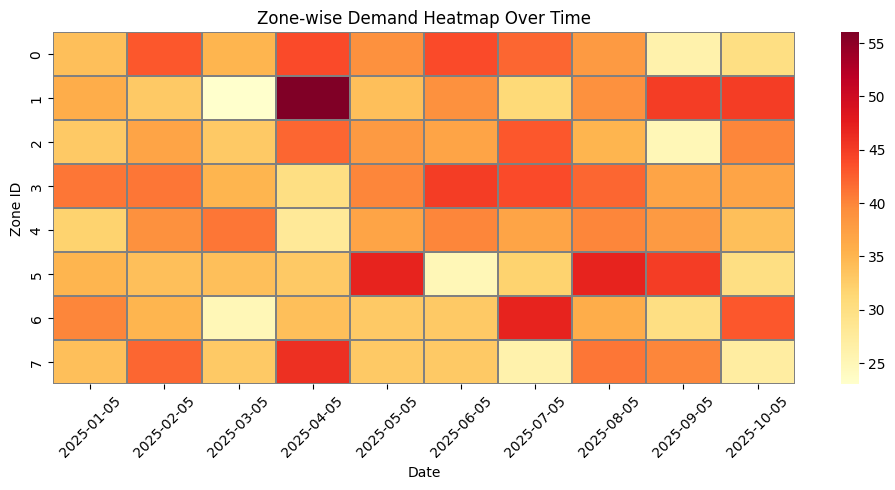

In [11]:
#Zone-wise Demand Heatmap Over Time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a pivot table for heatmap from existing `daily_counts`
heatmap_data = daily_counts.pivot_table(index='zone_id', columns='date', values='rides', fill_value=0)

# Plot heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(heatmap_data, cmap='YlOrRd', linewidths=0.1, linecolor='gray')
plt.title("Zone-wise Demand Heatmap Over Time")
plt.xlabel("Date")
plt.ylabel("Zone ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
import plotly.express as px
import pandas as pd

forecast_days = 5
forecast_data = []

for zone_id, model_data in forecast_results.items():
    best_model = min(model_data['metrics'], key=lambda k: model_data['metrics'][k][0])
    predictions = model_data[best_model][:forecast_days]

    for day_index, demand in enumerate(predictions):
        forecast_data.append({
            "zone_id": str(zone_id),
            "rides": demand,
            "date": f"Day {day_index + 1}"
        })

forecast_df = pd.DataFrame(forecast_data)

fig = px.bar(
    forecast_df,
    x='zone_id',
    y='rides',
    color='zone_id',
    animation_frame='date',
    title="Forecasted Demand per Zone (Next 5 Days)",
    labels={'rides': 'Predicted Ride Count', 'zone_id': 'Zone'}
)

fig.update_layout(
    xaxis=dict(type='category'),
    yaxis_title='Predicted Ride Count',
    xaxis_title='Zone',
    title_font_size=16
)

fig.show()

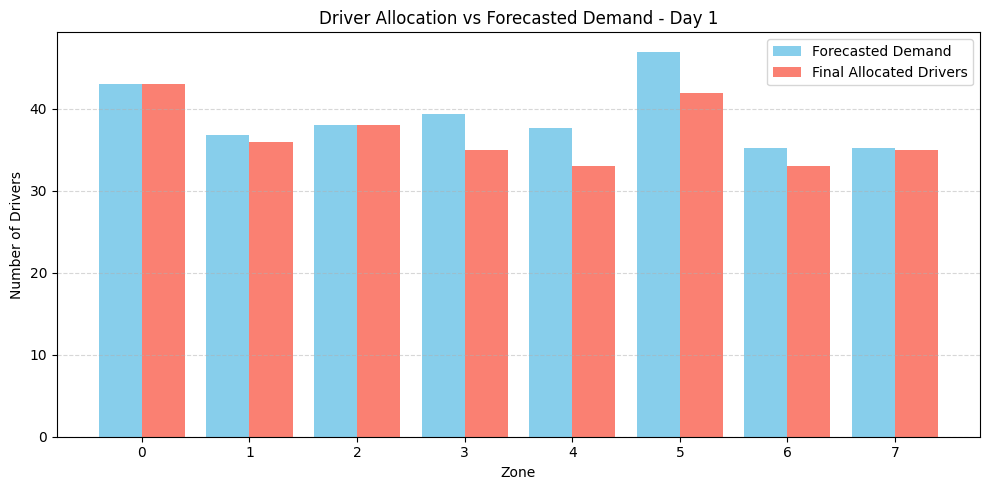

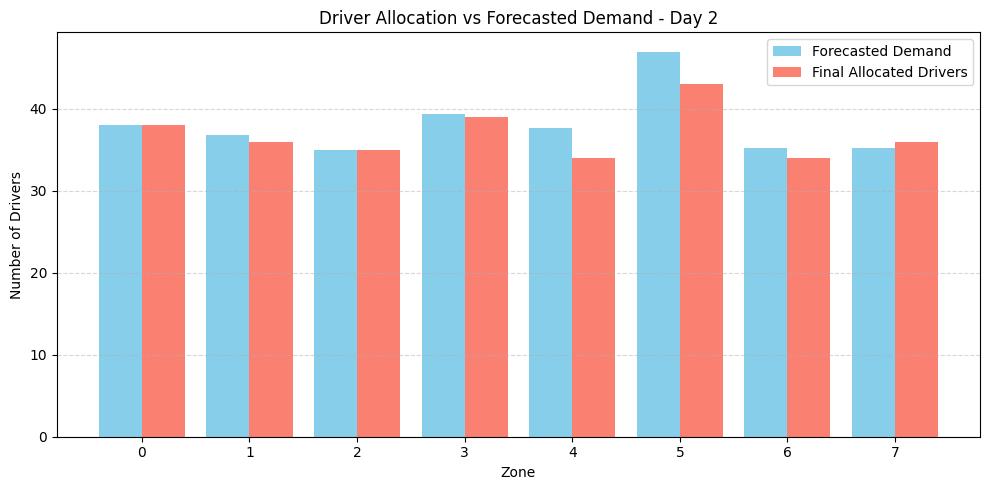

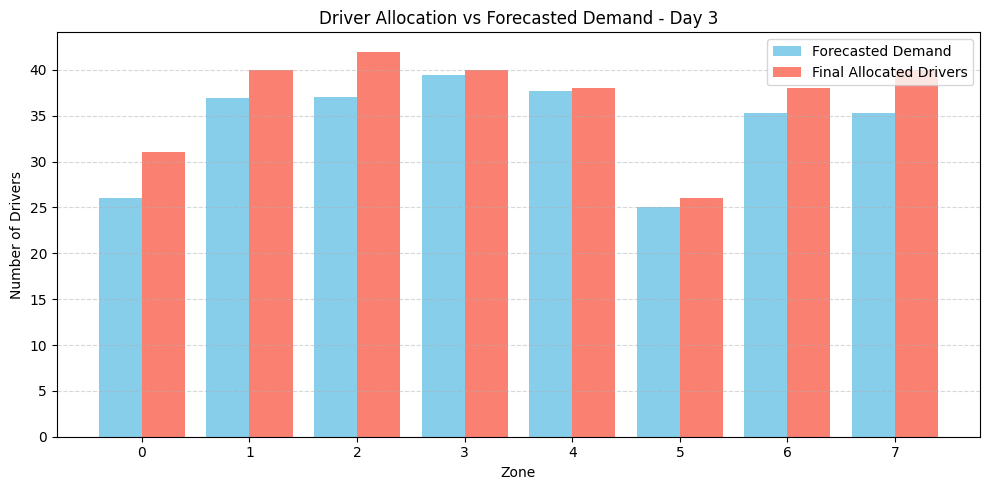

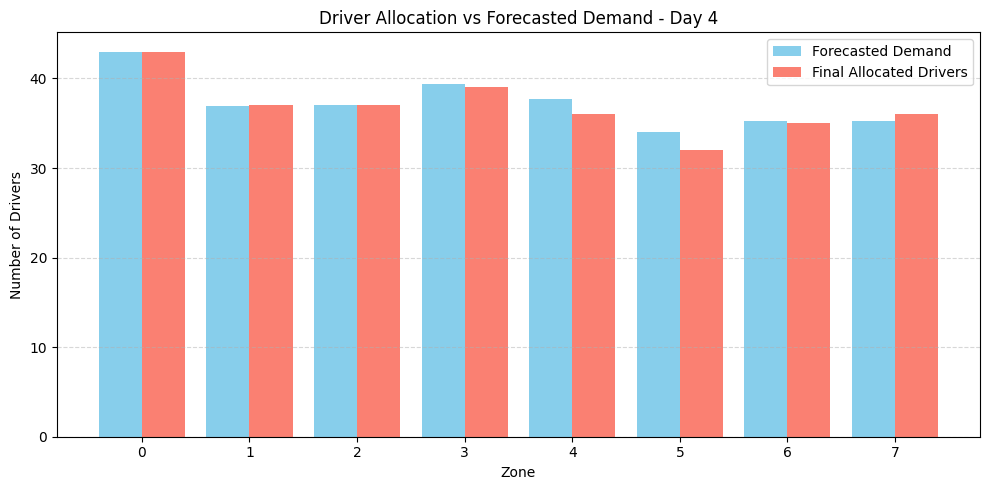

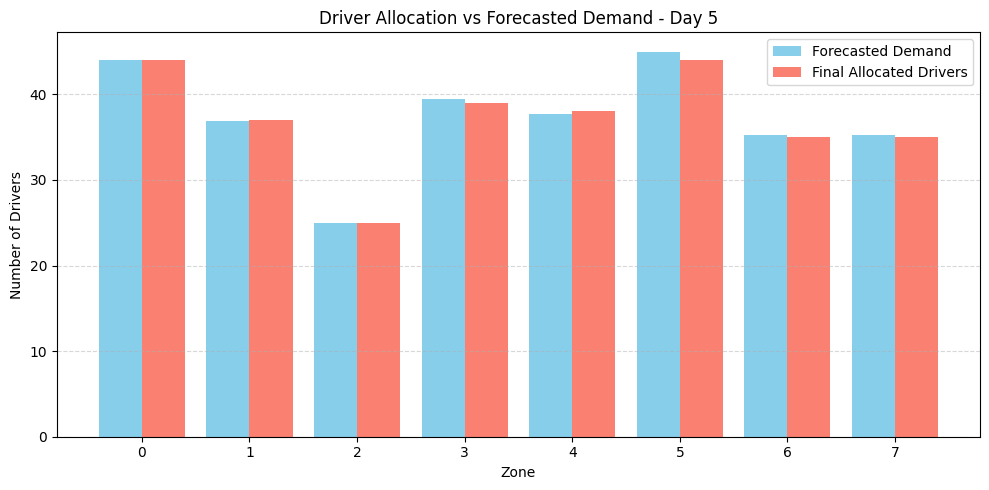

In [13]:
import matplotlib.pyplot as plt

# Configuration
total_available_drivers = 295
ALLOCATION_TOLERANCE = 0.9
MAX_BUFFER = 1.6

# Visualization loop for 5 forecast days
for forecast_day_index in range(5):
    predicted_demand = {}
    zone_buffers = {}

    # Step 1: Get predicted demand and buffers
    for zone, models in forecast_results.items():
        best_model = min(models['metrics'], key=lambda k: models['metrics'][k][0])
        demand = max(0, models[best_model][forecast_day_index])
        predicted_demand[zone] = demand

        mape = models['metrics'][best_model][2] / 100
        buffer = min(1 + mape, MAX_BUFFER)
        zone_buffers[zone] = buffer

    # Step 2: Initial buffered allocation
    driver_allocation = {
        zone: predicted_demand[zone] * zone_buffers[zone]
        for zone in predicted_demand
    }

    total_buffered = sum(driver_allocation.values())
    if total_buffered > total_available_drivers:
        scale = total_available_drivers / total_buffered
        for zone in driver_allocation:
            driver_allocation[zone] = round(driver_allocation[zone] * scale)
    else:
        for zone in driver_allocation:
            driver_allocation[zone] = round(driver_allocation[zone])

    # Step 3: Reallocate drivers (under- and over-zones)
    over_zones = []
    under_zones = []

    for zone in driver_allocation:
        surplus = driver_allocation[zone] - predicted_demand[zone]
        shortfall = predicted_demand[zone] - driver_allocation[zone]
        if shortfall > ALLOCATION_TOLERANCE:
            under_zones.append((zone, int(round(shortfall))))
        elif surplus > ALLOCATION_TOLERANCE:
            over_zones.append((zone, int(round(surplus))))

    for under_zone, need in under_zones:
        for i in range(len(over_zones)):
            over_zone, surplus = over_zones[i]
            if surplus > 0 and need > 0:
                move = min(surplus, need)
                driver_allocation[under_zone] += move
                driver_allocation[over_zone] -= move
                over_zones[i] = (over_zone, surplus - move)
                need -= move
            if need == 0:
                break

    # Step 4: Adjust allocations for fuel wastage
    for zone in driver_allocation:
        demand = predicted_demand[zone]
        drivers = driver_allocation[zone]
        surplus = drivers - demand

        if surplus > ALLOCATION_TOLERANCE:
            fuel_waste_km = int(surplus * (1 + surplus / (demand + 1e-5)) * 5)
        else:
            fuel_waste_km = 0

    # Step 5: Plot
    zones = sorted(predicted_demand.keys())
    forecasted = [round(predicted_demand[z], 2) for z in zones]
    allocated = [driver_allocation[z] for z in zones]

    plt.figure(figsize=(10, 5))
    x_pos = list(range(len(zones)))
    plt.bar([x - 0.2 for x in x_pos], forecasted, width=0.4, label='Forecasted Demand', color='skyblue')
    plt.bar([x + 0.2 for x in x_pos], allocated, width=0.4, label='Final Allocated Drivers', color='salmon')

    plt.title(f"Driver Allocation vs Forecasted Demand - Day {forecast_day_index + 1}")
    plt.xlabel("Zone")
    plt.ylabel("Number of Drivers")
    plt.xticks(x_pos, zones)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

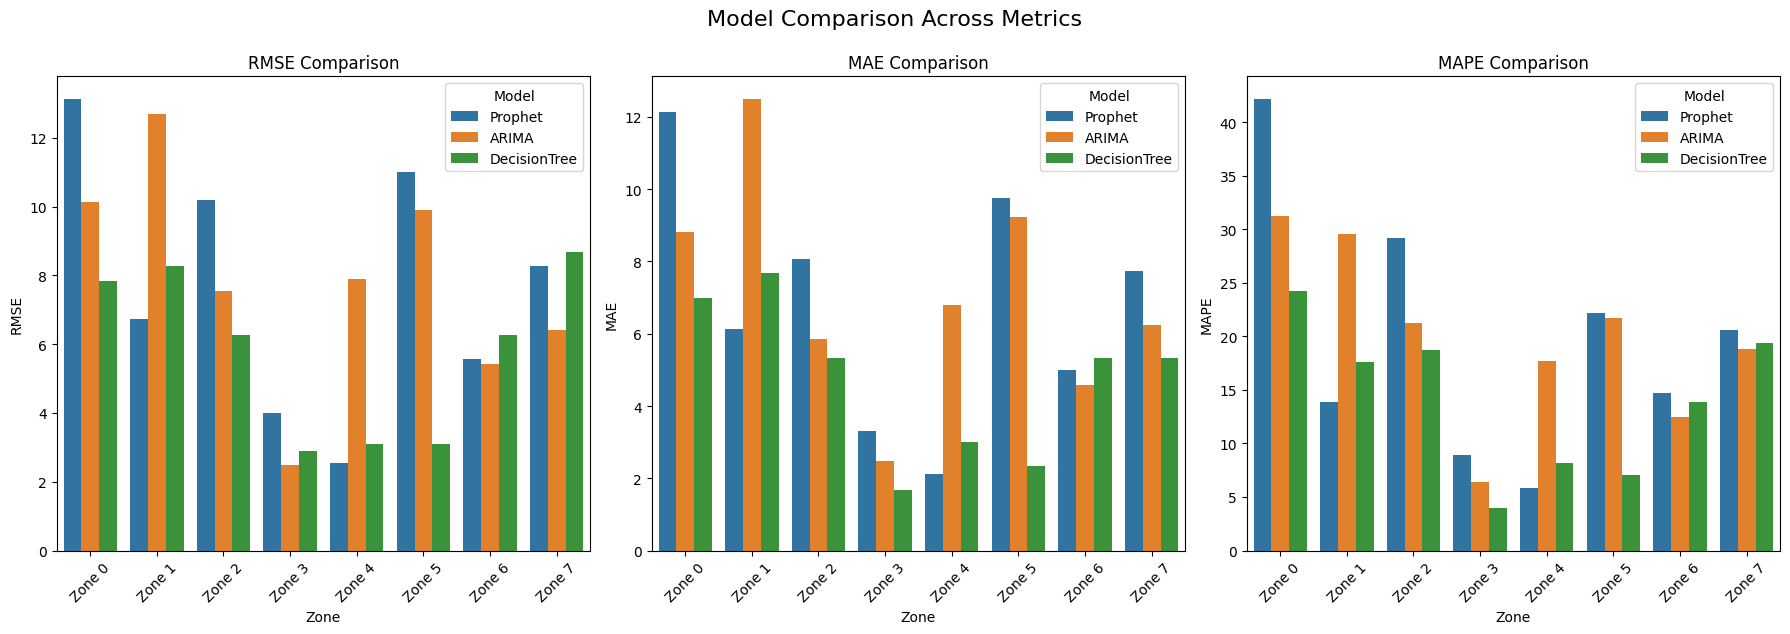

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data
metrics_dict = {'Zone': [], 'Model': [], 'RMSE': [], 'MAE': [], 'MAPE': []}

for zone, models in forecast_results.items():
    for model_name, (rmse, mae, mape) in models['metrics'].items():
        metrics_dict['Zone'].append(f"Zone {zone}")
        metrics_dict['Model'].append(model_name)
        metrics_dict['RMSE'].append(rmse)
        metrics_dict['MAE'].append(mae)
        metrics_dict['MAPE'].append(mape)

metrics_df = pd.DataFrame(metrics_dict)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

# Plot RMSE
sns.barplot(data=metrics_df, x="Zone", y="RMSE", hue="Model", ax=axes[0])
axes[0].set_title("RMSE Comparison")
axes[0].set_ylabel("RMSE")
axes[0].tick_params(axis='x', rotation=45)

# Plot MAE
sns.barplot(data=metrics_df, x="Zone", y="MAE", hue="Model", ax=axes[1])
axes[1].set_title("MAE Comparison")
axes[1].set_ylabel("MAE")
axes[1].tick_params(axis='x', rotation=45)

# Plot MAPE
sns.barplot(data=metrics_df, x="Zone", y="MAPE", hue="Model", ax=axes[2])
axes[2].set_title("MAPE Comparison")
axes[2].set_ylabel("MAPE")
axes[2].tick_params(axis='x', rotation=45)

# Layout and display
plt.tight_layout()
plt.suptitle("Model Comparison Across Metrics", fontsize=16, y=1.05)
plt.show()